In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

## Dataset Preparation

In [54]:
df = pd.read_csv('Telco_customer_churn.csv')

print(df.head())

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [56]:
print(df.isnull().sum())

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64


In [58]:
df.drop(columns=['Churn Reason'], inplace=True)

print(df.columns)

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV'],
      dtype='object')


In [60]:
print(df.dtypes)

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
dtype: object


In [62]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

print(df['Total Charges'].isnull().sum())

11


In [64]:
df = df.dropna(subset=['Total Charges'])

print(df['Total Charges'].isnull().sum())
print(f"Shape of the dataset after dropping rows: {df.shape}")

0
Shape of the dataset after dropping rows: (7032, 32)


## Exploratory Data Analysis

In [67]:
print(df.describe())

        Count      Zip Code     Latitude    Longitude  Tenure Months  \
count  7032.0   7032.000000  7032.000000  7032.000000    7032.000000   
mean      1.0  93523.032565    36.283307  -119.799215      32.421786   
std       0.0   1865.515958     2.456118     2.157588      24.545260   
min       1.0  90001.000000    32.555828  -124.301372       1.000000   
25%       1.0  92102.000000    34.030915  -121.815412       9.000000   
50%       1.0  93552.500000    36.391777  -119.735410      29.000000   
75%       1.0  95354.000000    38.227285  -118.043237      55.000000   
max       1.0  96161.000000    41.962127  -114.192901      72.000000   

       Monthly Charges  Total Charges  Churn Value  Churn Score         CLTV  
count      7032.000000    7032.000000  7032.000000  7032.000000  7032.000000  
mean         64.798208    2283.300441     0.265785    58.715301  4401.445108  
std          30.085974    2266.771362     0.441782    21.531321  1182.414266  
min          18.250000      18.8000

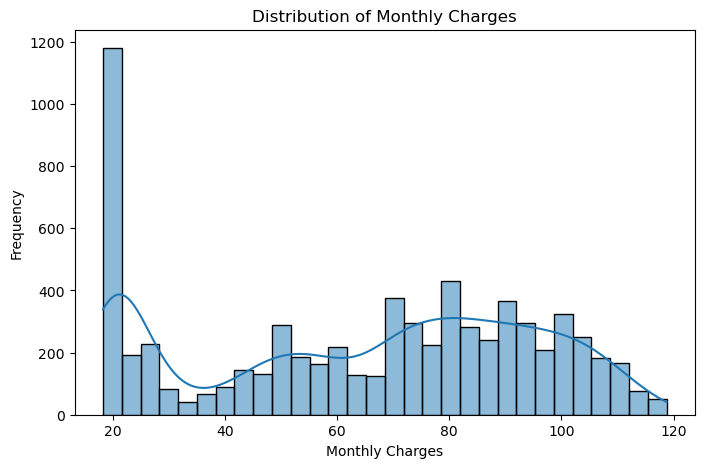

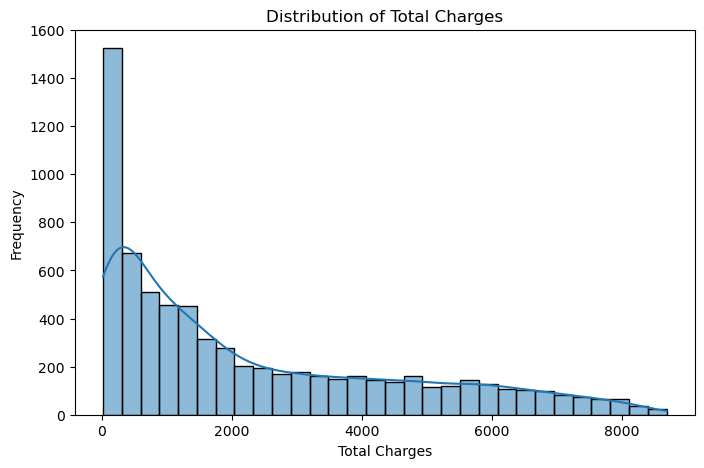

In [69]:
# monthly charges
plt.figure(figsize=(8, 5))
sns.histplot(df['Monthly Charges'], kde=True, bins=30)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()

# total charges
plt.figure(figsize=(8, 5))
sns.histplot(df['Total Charges'], kde=True, bins=30)
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

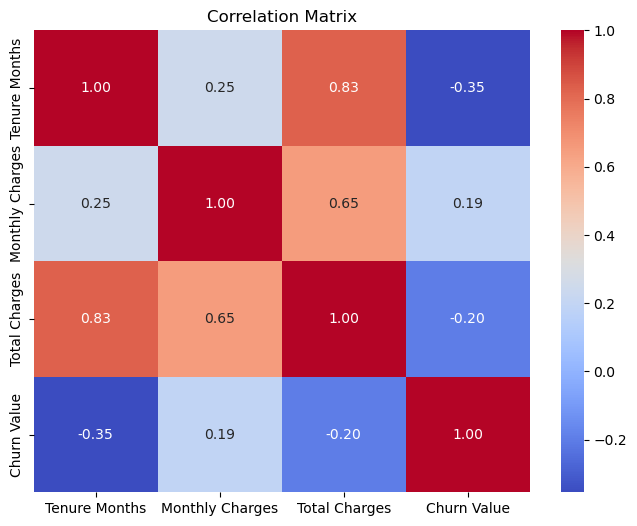

In [71]:
correlation_matrix = df[['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Data Preprocessing

In [74]:
columns_to_drop = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long']
df = df.drop(columns=columns_to_drop)

categorical_columns = [
    'Gender', 'Senior Citizen', 'Partner', 'Dependents',
    'Phone Service', 'Multiple Lines', 'Internet Service',
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies',
    'Contract', 'Paperless Billing', 'Payment Method'
]

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print(df.head())

    Latitude   Longitude  Tenure Months  Monthly Charges  Total Charges  \
0  33.964131 -118.272783              2            53.85         108.15   
1  34.059281 -118.307420              2            70.70         151.65   
2  34.048013 -118.293953              8            99.65         820.50   
3  34.062125 -118.315709             28           104.80        3046.05   
4  34.039224 -118.266293             49           103.70        5036.30   

  Churn Label  Churn Value  Churn Score  CLTV  Gender_Male  ...  \
0         Yes            1           86  3239         True  ...   
1         Yes            1           67  2701        False  ...   
2         Yes            1           86  5372        False  ...   
3         Yes            1           84  5003        False  ...   
4         Yes            1           89  5340         True  ...   

   Streaming TV_No internet service  Streaming TV_Yes  \
0                             False             False   
1                             Fa

In [79]:
X = df.drop(columns=['Churn Label', 'Churn Value'])
y = df['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (4922, 34), X_test shape: (2110, 34)
y_train shape: (4922,), y_test shape: (2110,)


## Model Training and Evaluation

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000, random_state=42)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1522
           1       0.86      0.83      0.85       588

    accuracy                           0.92      2110
   macro avg       0.90      0.89      0.90      2110
weighted avg       0.92      0.92      0.92      2110

Confusion Matrix:
[[1444   78]
 [  98  490]]
ROC-AUC Score: 0.98


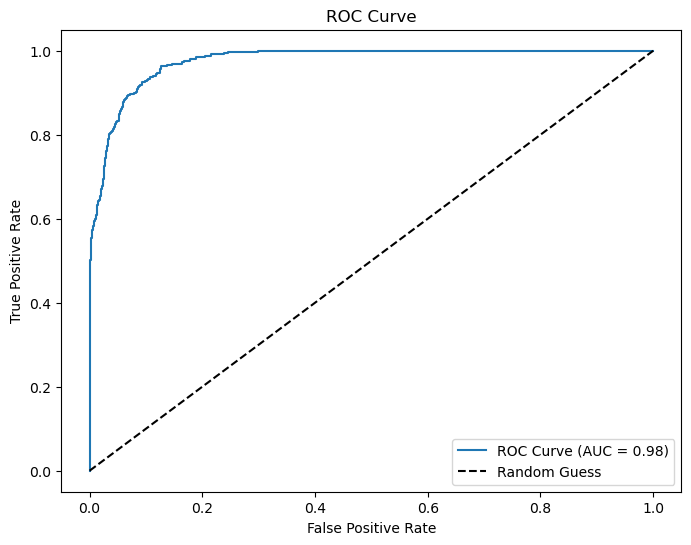

In [85]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [87]:
X_test['Churn_Probabilities'] = y_prob
X_test['Churn_Predicted'] = y_pred

X_test['Actual_Churn'] = y_test.values

X_test.to_csv('Churn_Predictions.csv', index=False)

print("Predictions exported to 'Churn_Predictions.csv'")

Predictions exported to 'Churn_Predictions.csv'


## Data Visualization

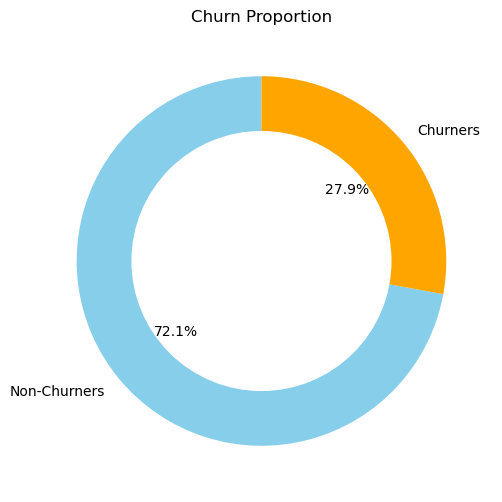

In [90]:
# churn proportions calculating
churn_counts = y_test.value_counts()
labels = ['Non-Churners', 'Churners']

# donut chart
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))
plt.title('Churn Proportion')
plt.show()

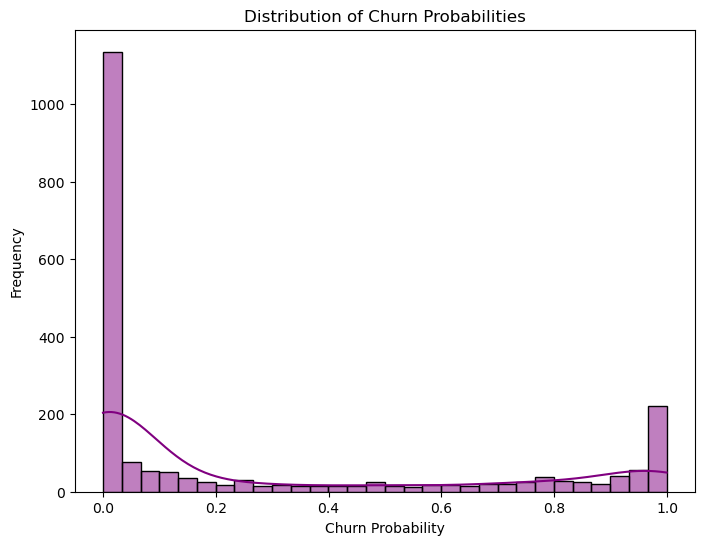

In [92]:
# histogram of churn probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, kde=True, bins=30, color='purple')
plt.title('Distribution of Churn Probabilities')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.show()

In [94]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

Accuracy: 0.92
Precision: 0.86
Recall: 0.83
F1 Score: 0.85
ROC-AUC Score: 0.98


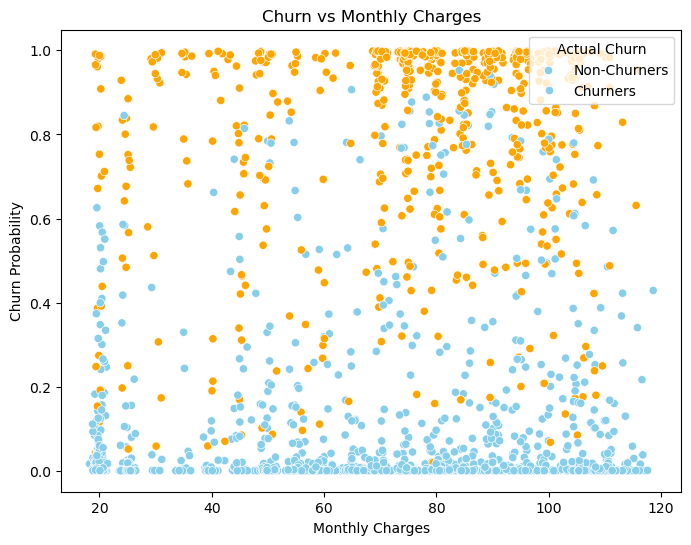

In [96]:
# scatter plot of monthly charges vs churn probabilities
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test['Monthly Charges'], y=y_prob, hue=y_test, palette={0: 'skyblue', 1: 'orange'})
plt.title('Churn vs Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Churn Probability')
plt.legend(title='Actual Churn', loc='upper right', labels=['Non-Churners', 'Churners'])
plt.show()

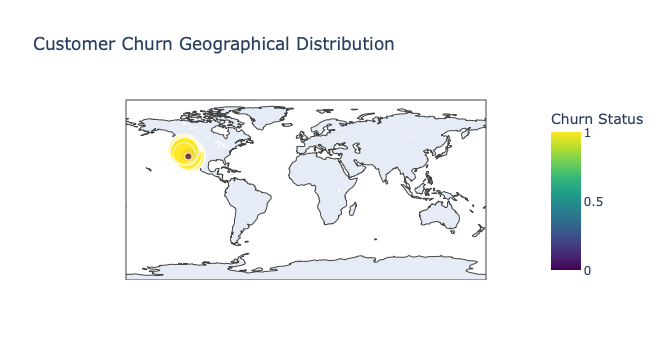

In [98]:
# geographical scatter map
geo_df = X_test.copy()
geo_df['Churn_Probabilities'] = y_prob
geo_df['Actual_Churn'] = y_test

fig = px.scatter_geo(geo_df,
                     lat=geo_df['Latitude'],
                     lon=geo_df['Longitude'],
                     color='Actual_Churn',
                     size='Churn_Probabilities',
                     title="Customer Churn Geographical Distribution",
                     labels={'Actual_Churn': 'Churn Status'},
                     color_continuous_scale='Viridis')
fig.show()

## Additional Statistical Analysis and Non-Parametric Modeling

In [141]:
churners = df[df['Churn Value'] == 1]['Monthly Charges']
non_churners = df[df['Churn Value'] == 0]['Monthly Charges']

def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(sample.mean())
    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return lower, upper

churn_ci = bootstrap_ci(churners)
non_churn_ci = bootstrap_ci(non_churners)

print(f"95% Confidence Interval for Monthly Charges, churners: {churn_ci}")
print(f"95% Confidence Interval for Monthly Charges non-churners: {non_churn_ci}")

95% Confidence Interval for Monthly Charges, churners: (73.31979802033173, 75.49747726056715)
95% Confidence Interval for Monthly Charges non-churners: (60.448637177997284, 62.18411001355801)


In [143]:
# independent t-test
t_stat, p_value = ttest_ind(churners, non_churners, equal_var=False)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.5f}")
if p_value < 0.05:
    print("difference in monthly charges between churners and non-churners is statistically high.")
else:
    print("no high difference in monthly charges between churners and non-churners.")

T-statistic: 18.34, P-value: 0.00000
difference in monthly charges between churners and non-churners is statistically high.


In [147]:
# decision tree classifier
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train_scaled, y_train)

# predicting churn
y_tree_pred = tree_model.predict(X_test_scaled)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_tree_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1522
           1       0.91      0.80      0.85       588

    accuracy                           0.92      2110
   macro avg       0.92      0.89      0.90      2110
weighted avg       0.92      0.92      0.92      2110

